<a href="https://colab.research.google.com/github/Mateus-Maciel/projetos-1-/blob/main/Redes_Convolucional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import torch
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

In [2]:
DATA_DIR = "/content/drive/MyDrive/Datasets/Cifar10"
CATEGORIES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
cifar10_train=CIFAR10("DATA_DIR",train=True,download=True)
cifar10_test=CIFAR10("DATA_DIR",train=False,download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 49149310.06it/s]


Extracting DATA_DIR/cifar-10-python.tar.gz to DATA_DIR
Files already downloaded and verified


In [4]:
(len(cifar10_train),len(cifar10_test))

(50000, 10000)

In [5]:
# Vamos visualizar algumas imagens dos dados

def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8, 8))
  rows, cols = 2, 2
  for i in range(1, 5):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(CATEGORIES[label])
      plt.axis("off")
      if istensor:
        plt.imshow(img.squeeze().permute(1, 2, 0))
      else:
        plt.imshow(img)
  plt.show()

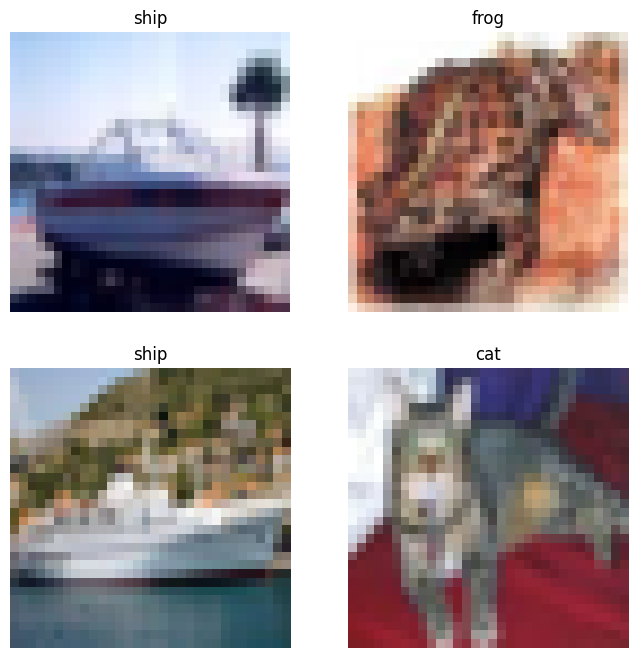

In [6]:
lookat_dataset(cifar10_train)

In [7]:
# Aplicando transformações e dividindo os dados

prep_transform = T.Compose([
                    T.ToTensor(),
                    T.Normalize(
                        (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
                    )
                  ])

# Applying a transform
tensor_train = CIFAR10(DATA_DIR, train=True, download=False,
                         transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False,
                         transform=prep_transform)


In [8]:
# Normalizing data
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape


torch.Size([3, 32, 32, 50000])

In [9]:
imgs.view(3, -1).mean(dim=1)

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [10]:
imgs.view(3, -1).std(dim=1)

tensor([1.0001, 0.9999, 1.0000])

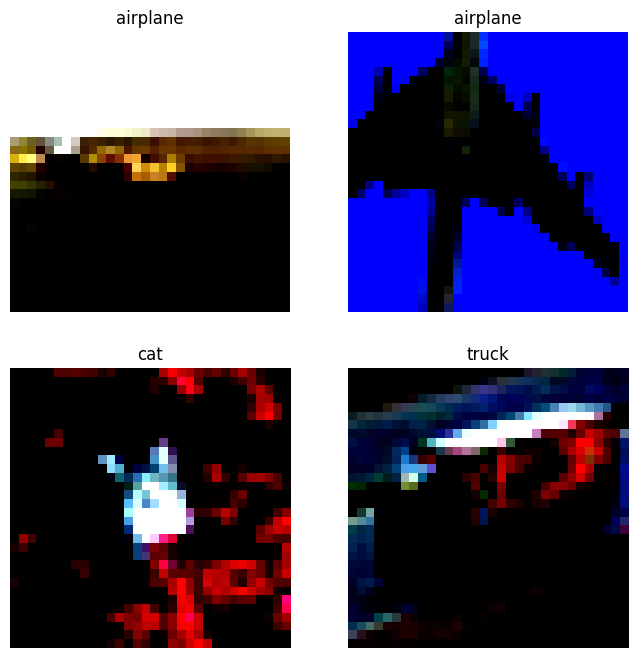

In [11]:
lookat_dataset(tensor_train, True)

In [12]:
#Criando DataLoaders

batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=False)

In [13]:
#Construindo uma rede MLP
#MLP = MultiLayer Perceptron (multi camadas de perceptrons)

from torch import nn

class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    self.layers = nn.Sequential(
        nn.Linear(3 * 32*32, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )

  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)


In [14]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [15]:
model = MLPClassifier().to(device)

In [16]:
#Escolhendo os hiperparâmetros de otimização


loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [17]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)

    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)

In [18]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

In [19]:
# Treinando a rede

epochs = 41
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")

  test_loss = validate(model, test_loader, loss_func)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.2958280299325735
Epoch: 10; Train Loss: 1.851905807662193
Epoch: 20; Train Loss: 1.6438682129620896
Epoch: 30; Train Loss: 1.5246000731997478
Epoch: 40; Train Loss: 1.4186910467074656


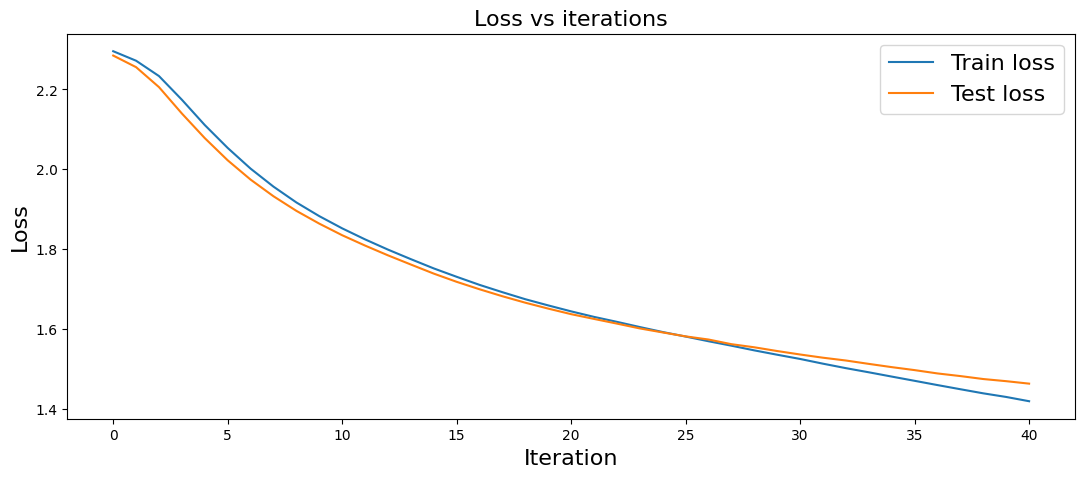

In [20]:
losses = {"Train loss": train_losses, "Test loss": test_losses}
plot_losses(losses)


In [23]:
# Avaliando o resultado

def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1),
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))

In [24]:
confusion_matrix = evaluate_accuracy(model, test_loader, CATEGORIES)

Accuracy for class airplane is: 53.2 %
Accuracy for class automobile is: 63.3 %
Accuracy for class bird  is: 33.3 %
Accuracy for class cat   is: 31.1 %
Accuracy for class deer  is: 33.6 %
Accuracy for class dog   is: 40.1 %
Accuracy for class frog  is: 56.6 %
Accuracy for class horse is: 56.0 %
Accuracy for class ship  is: 64.8 %
Accuracy for class truck is: 52.6 %
Global acccuracy is 48.5


<Axes: >

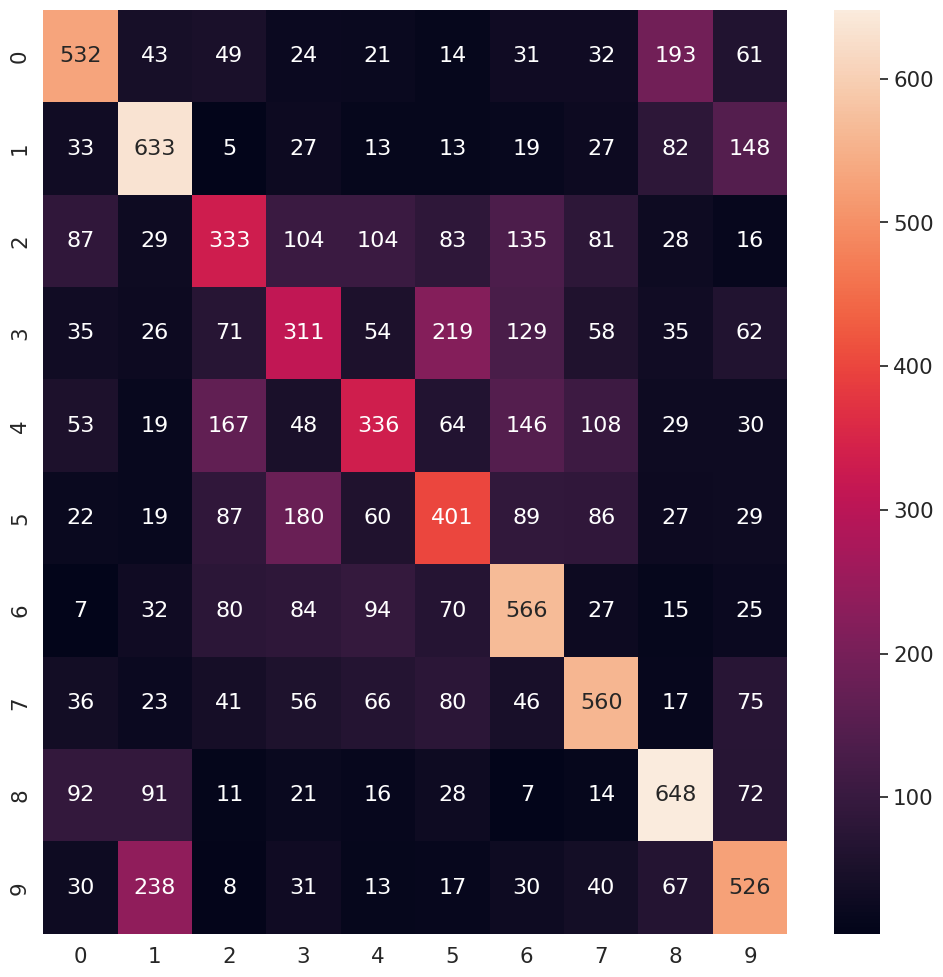

In [25]:
import seaborn as sn

plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d')

In [26]:
#Construindo uma rede neural de convolução


class ConvolutionalModel(nn.Module):
  def __init__(self):
      super().__init__()
      self.convlayers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

      )

      self.linearlayers = nn.Sequential(
          nn.Linear(1152, 256),
          nn.ReLU(),
          nn.Linear(256, 10)
      )

  def forward(self, x):
      x = self.convlayers(x)
      x = torch.flatten(x, 1)
      return self.linearlayers(x)

In [27]:
convmodel = ConvolutionalModel().to(device)

In [28]:
loss_func2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(convmodel.parameters(), lr=0.001)

In [29]:
epochs = 51
conv_train_losses = []
conv_test_losses = []
for t in range(epochs):
  train_loss = train(convmodel, train_loader, loss_func2, optimizer2)
  conv_train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  test_loss = validate(convmodel, test_loader, loss_func2)
  conv_test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.285485652706507
Epoch: 10; Train Loss: 1.7644978662585968
Epoch: 20; Train Loss: 1.4797133839953587
Epoch: 30; Train Loss: 1.340907612724987
Epoch: 40; Train Loss: 1.2377791621953325
Epoch: 50; Train Loss: 1.1510849635466895


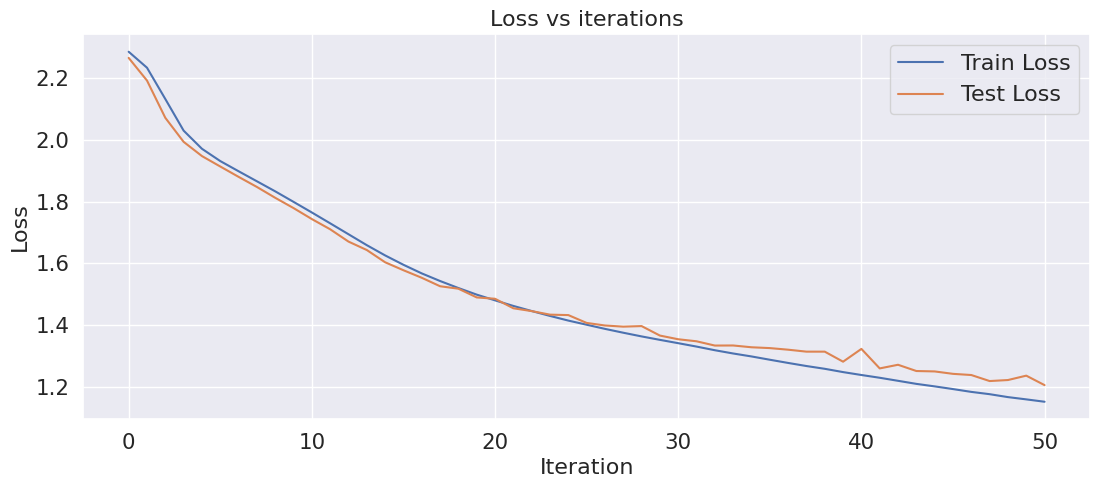

In [30]:
conv_losses = {"Train Loss": conv_train_losses, "Test Loss": conv_test_losses}
plot_losses(conv_losses)

In [31]:
conv_confusion_matrix = evaluate_accuracy(convmodel, test_loader, CATEGORIES)

Accuracy for class airplane is: 61.1 %
Accuracy for class automobile is: 71.4 %
Accuracy for class bird  is: 47.9 %
Accuracy for class cat   is: 27.9 %
Accuracy for class deer  is: 55.9 %
Accuracy for class dog   is: 52.5 %
Accuracy for class frog  is: 59.4 %
Accuracy for class horse is: 59.4 %
Accuracy for class ship  is: 73.5 %
Accuracy for class truck is: 63.2 %
Global acccuracy is 57.2


<Axes: >

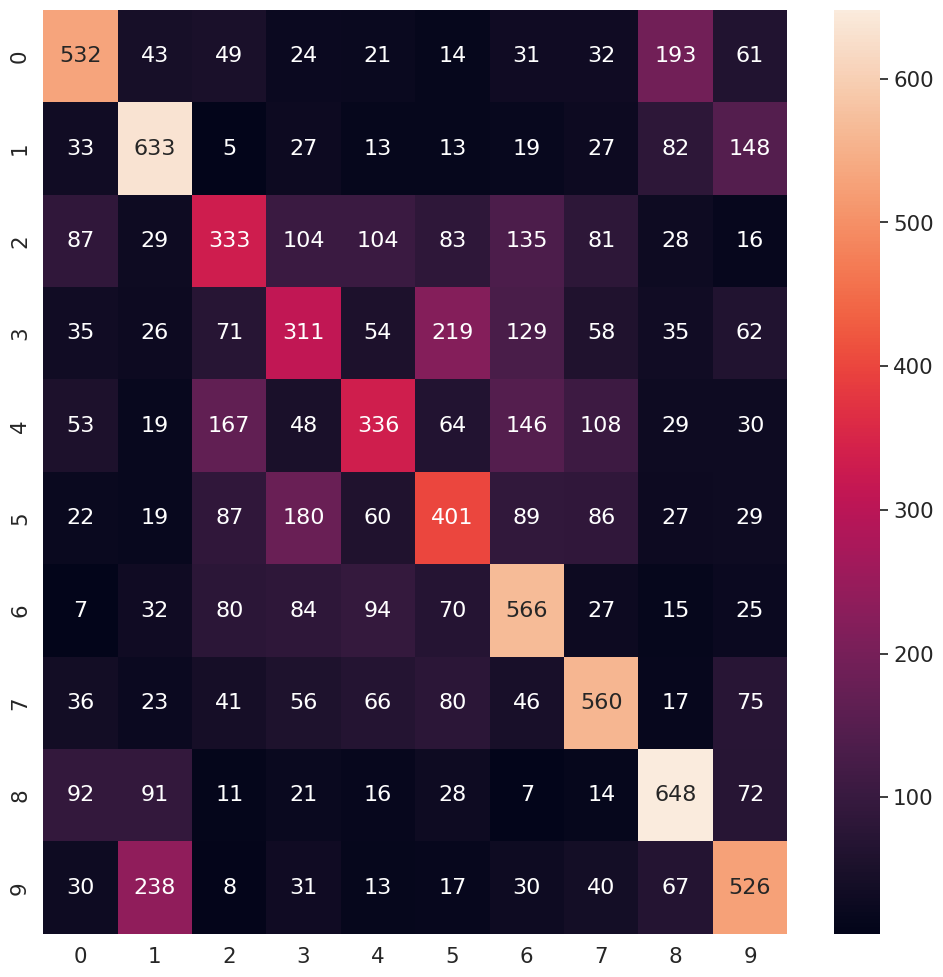

In [32]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d')

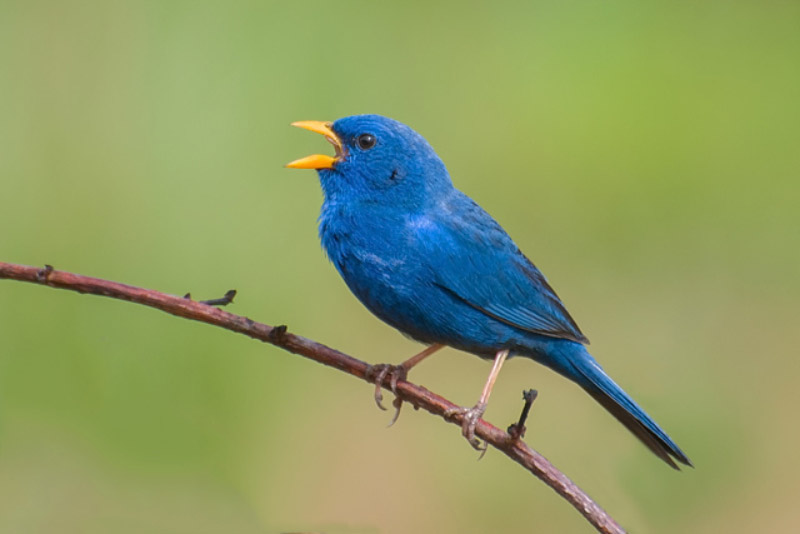

In [46]:
#Testando em exemplo próprio

from PIL import Image
from IPython.display import display
img = Image.open('drive/MyDrive/Datasets/Cifar10/pássaro1.jpg')
display(img)

In [47]:
prep_transforms = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize( (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616) )
     ]
)
img_tensor = prep_transforms(img)

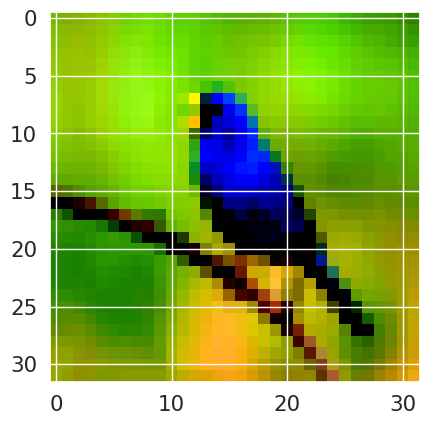

In [48]:
plt.imshow(img_tensor.permute(1,2, 0))

In [49]:
batch = img_tensor.unsqueeze(0).to(device)

In [50]:
convmodel.eval()


ConvolutionalModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [51]:
output = convmodel(batch)
output

tensor([[ 2.2432, -0.6613,  4.3642, -1.0925,  1.7876, -0.3394, -2.2200, -0.2674,
         -1.7749, -1.6426]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [52]:
logits = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}
for i, classname in enumerate(CATEGORIES):
  prob = logits[0][i].item()
  print(f"{classname} score: {prob:.2f}")
  prob_dict[classname] = [prob]

airplane score: 9.74
automobile score: 0.53
bird score: 81.20
cat score: 0.35
deer score: 6.17
dog score: 0.74
frog score: 0.11
horse score: 0.79
ship score: 0.18
truck score: 0.20


In [53]:
import pandas as pd

In [54]:
df_prob = pd.DataFrame.from_dict(prob_dict)

<Axes: >

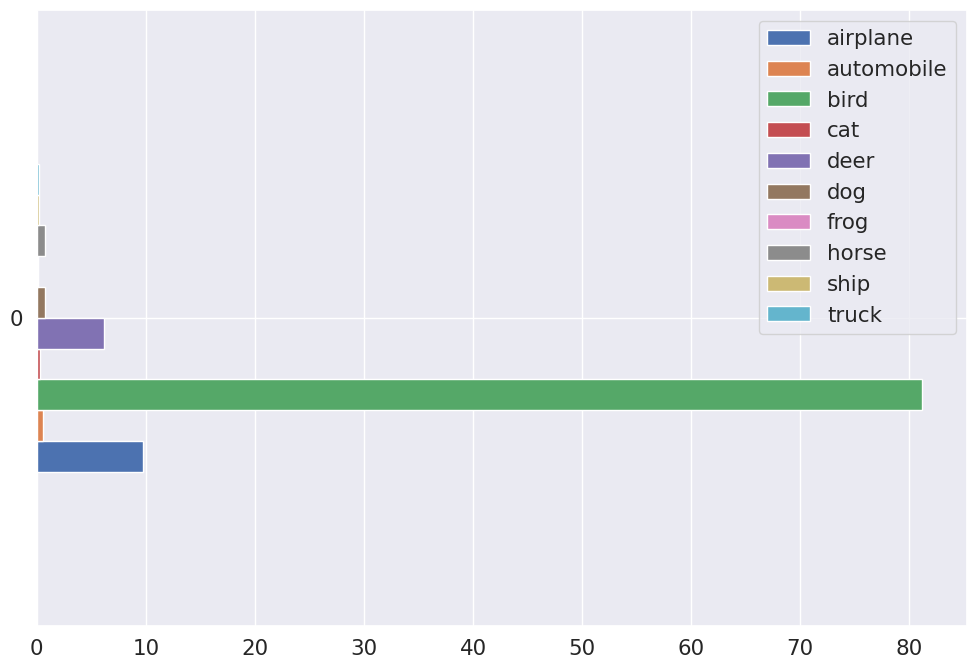

In [55]:
df_prob.plot(kind='barh', figsize=(12, 8))
